# IRC belief to neural data 

Using IRC, we infered monkey's belief from their behavior.
We can then fit the neural acitivty to the behavioral inferred belief, to see the benifit of using IRC.


In [22]:
# imports
import sys
import os
os.chdir('/workspaces/ffsb/test/neural')
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))
os.chdir('/workspaces/ffsb')

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
import scipy.interpolate as interpolate
import random
from sklearn.metrics import mean_squared_error, r2_score
from plot_ult import *
import configparser
from sklearn import linear_model
from pathlib import Path
from notification import notify
from env_config import Config
from firefly_task import ffacc_real
from monkey_functions import *
from InverseFuncs import *
from stable_baselines3 import TD3
import time
from torch.distributions.multivariate_normal import MultivariateNormal
import heapq
import warnings
import matplotlib.pyplot as plt
import copy
from cmaes import CMA
from numpy.lib.npyio import save
import pandas as pd
import pickle
from scipy.io import loadmat
from scipy.interpolate import interp1d
from datetime import datetime
from copy import deepcopy
from firefly_utils.lfp_class import lfp_class
from firefly_utils.behav_class import *
from firefly_utils.spike_times_class import spike_counts
from firefly_utils.data_handler import data_handler
from matplotlib import pyplot as plt
from numpy import pi
from sklearn.cross_decomposition import CCA
import torch
import numpy as np

## Load neural data (.mat file) and behaviral data (from IRC)
the neural data file also has some behaivral data, such as current velocity.
we can use this as a sanity check to making sure things are right.

In [23]:
# load neural data

config = configparser.ConfigParser()
config.read_file(open('privateconfig'))
resdir=config['Datafolder']['data']
resdir = Path(resdir)


dat = loadmat(resdir/'neuraltest/m53s31.mat') # this is a example session with good recording, more neurons
# dat = loadmat(resdir/'neural/m53s36.mat') # this is a pert example


behav_stat_key = 'behv_stats'
spike_key = 'units'
behav_dat_key = 'trials_behv'
lfp_key = 'lfps'

pre_trial_dur = 0.5
post_trial_dur = 0.5
exp_data = data_handler(dat, behav_dat_key, spike_key, lfp_key, 
                        behav_stat_key, pre_trial_dur=pre_trial_dur,             extract_fly_and_monkey_xy=True,
                        post_trial_dur=post_trial_dur,extract_cartesian_eye_and_firefly=True,
                        lfp_beta=None, lfp_alpha=None, extract_lfp_phase=True)
# list(exp_data.behav.continuous.__dict__.keys())
exp_data.set_filters('all', True)
ts = exp_data.rebin_time_stamps(0.1)
t_targ=dict_to_vec(exp_data.behav.events.t_targ)
t_start=t_targ
t_stop = dict_to_vec(exp_data.behav.events.t_stop)
var_names = 'rad_vel','ang_vel','x_monk','y_monk', 'eye_hori', 'eye_vert','x_fly_screen','z_fly_screen','x_eye_screen','z_eye_screen',"x_fly_rel","y_fly_rel","ang_vel"
y,X,trial_idx = exp_data.concatenate_inputs(*var_names,t_start=t_start,t_stop=t_stop, time_stamps=ts)

trials=np.unique(trial_idx)
yes=0
total=0
for itrial in range(len(trials)):
    if len(X['x_fly_rel'][trial_idx==trials[itrial]])<1:
        continue
    d=(X['x_fly_rel'][trial_idx==trials[itrial]][-1]**2 + X['y_fly_rel'][trial_idx==trials[itrial]][-1]**2)**0.5
    if d < 65: yes+=1
    total+=1
print(f'number of trial: {len(trials)}, \nsession success rate is ', yes/total)


unable to extract pairs, different blocks number
no eyetracking...
no normalized t_ptb (t_ptbn)
['all', 'reward', 'density', 'ptb', 'microstim', 'landmark', 'replay', 'controlgain', 'firefly_fullON']
Succesfully set filter
number of trial: 700, 
session success rate is  0.5642857142857143


In [24]:
brainarea=dat['units']['brain_area']
brainarea

array([[array(['PPC'], dtype='<U3'), array(['PPC'], dtype='<U3'),
        array(['PFC'], dtype='<U3'), array(['PFC'], dtype='<U3'),
        array(['PFC'], dtype='<U3'), array(['PFC'], dtype='<U3'),
        array(['PFC'], dtype='<U3'), array(['PFC'], dtype='<U3'),
        array(['PFC'], dtype='<U3'), array(['PFC'], dtype='<U3'),
        array(['PFC'], dtype='<U3'), array(['PFC'], dtype='<U3'),
        array(['PFC'], dtype='<U3'), array(['PFC'], dtype='<U3'),
        array(['PFC'], dtype='<U3'), array(['PFC'], dtype='<U3'),
        array(['PFC'], dtype='<U3'), array(['PFC'], dtype='<U3'),
        array(['PPC'], dtype='<U3'), array(['PFC'], dtype='<U3'),
        array(['PFC'], dtype='<U3'), array(['PFC'], dtype='<U3'),
        array(['PFC'], dtype='<U3'), array(['PFC'], dtype='<U3'),
        array(['PFC'], dtype='<U3'), array(['PFC'], dtype='<U3'),
        array(['PPC'], dtype='<U3'), array(['PFC'], dtype='<U3'),
        array(['PFC'], dtype='<U3'), array(['PPC'], dtype='<U3'),
        ar

In [25]:
# load behavioral data

with open(resdir/'neuraltest/res/m53s31_0223newformatbelief', 'rb') as f:
    res = pickle.load(f)

y_ = res['y']
X = {k: res[k] for k in ['rad_vel', 'ang_vel', 'x_monk', 'y_monk']}
trial_idx = res['trial_idx']
beliefs = res['belief']
covs = res['covs']
s = np.vstack([v for v in X.values()])
s = s.T


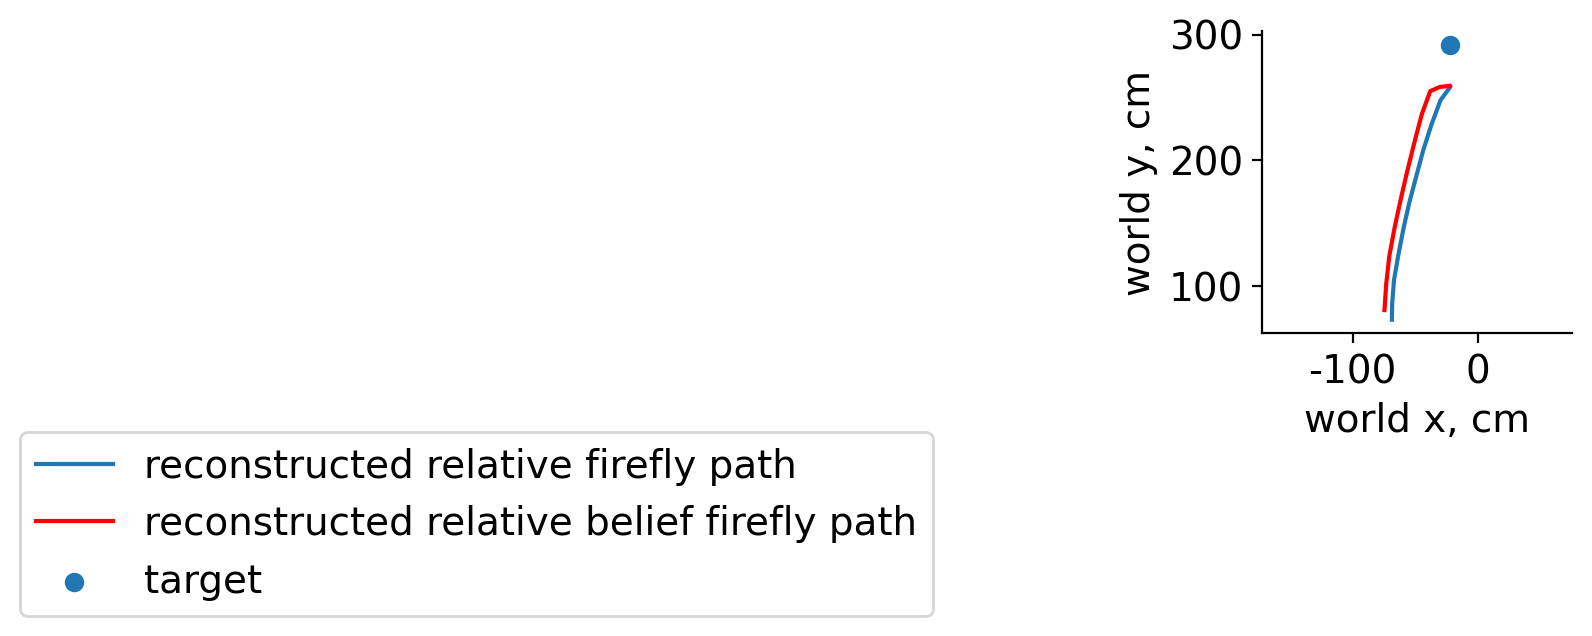

In [26]:
# sanity check, reconstruct relative belief path vs state path (tiny shift for visualization)

itrial=0
itrial+=1
# check, reconstruct relative belief path vs state path
with initiate_plot(2,2,200) as fig:
    ax=fig.add_subplot(111)
    # plt.plot(X['x_monk'][trial_idx==trials[itrial]], X['y_monk'][trial_idx==trials[itrial]],label='monkey path')
    # plt.plot(X['x_fly_rel'][trial_idx==trials[itrial]], X['y_fly_rel'][trial_idx==trials[itrial]]-32.5,label='relative firefly path')
    
    xr, yr=world2mk(X['x_monk'][trial_idx==trials[itrial]],X['y_monk'][trial_idx==trials[itrial]],X['ang_vel'][trial_idx==trials[itrial]],exp_data.behav.continuous.x_fly[trials[itrial]], exp_data.behav.continuous.y_fly[trials[itrial]])
    plt.plot(xr, yr-32.5,label='reconstructed relative firefly path')

    xr, yr=world2mk(beliefs[trial_idx==trials[itrial]][:,0],beliefs[trial_idx==trials[itrial]][:,1],X['ang_vel'][trial_idx==trials[itrial]],exp_data.behav.continuous.x_fly[trials[itrial]], exp_data.behav.continuous.y_fly[trials[itrial]])
    plt.plot(xr, yr-32.5,label='reconstructed relative belief firefly path', color='red')

    plt.scatter(exp_data.behav.continuous.x_fly[trials[itrial]], exp_data.behav.continuous.y_fly[trials[itrial]],label='target')
    plt.axis('equal')
    quickspine(ax)
    ax.set_xlabel('world x, cm')
    ax.set_ylabel('world y, cm')
    quickleg(ax)
    # quicksave('example overhead mk position relative itrial{}'.format(itrial))


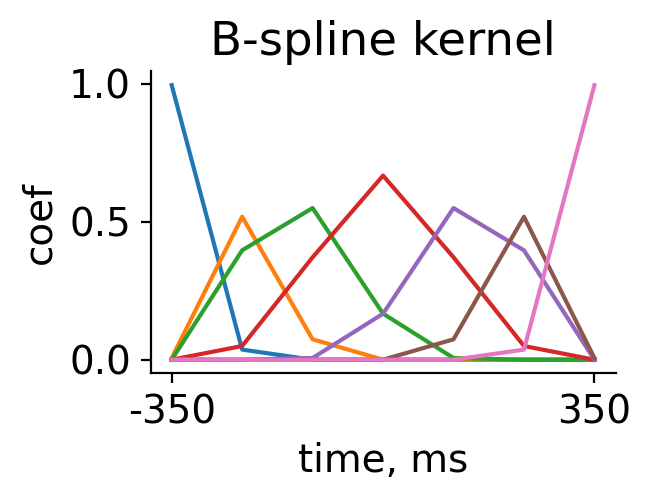

In [27]:
# use b-spline to process neural data

kernel_len = 7  # should be about +- 325ms
knots = np.hstack(([-1.001]*3, np.linspace(-1.001, 1.001, 5), [1.001]*3))
tp = np.linspace(-1., 1., kernel_len)
bX = splineDesign(knots, tp, ord=4, der=0, outer_ok=False)
with initiate_plot(3, 2, 200) as f:
    ax = f.add_subplot(111)
    plt.plot(bX)
    plt.title('B-spline kernel')
    quickspine(ax)
    plt.xticks([0, kernel_len-1])
    ax.set_xticklabels([-kernel_len*50, kernel_len*50])
    plt.xlabel('time, ms')
    plt.ylabel('coef')


with suppress():
    modelX = convolve_loop(y_.T, trial_idx, bX)  # ts, neurons
pos_xy = np.hstack((X['x_monk'].reshape(-1, 1),
                   X['y_monk'].reshape(-1, 1)))  # ts, xy
# remove bad data
non_nan = ~np.isnan(pos_xy.sum(axis=1))
modelX = modelX[non_nan]
pos_xy = pos_xy[non_nan]
belief_xy = beliefs[:, [0, 1]][non_nan]

In [28]:
# calculate relative beliefs and states

states_rel, belief_rel = [], []
for itrial in range(len(trials)):
    xr, yr = world2mk(X['x_monk'][trial_idx == trials[itrial]], X['y_monk'][trial_idx == trials[itrial]], X['ang_vel'][trial_idx ==
                      trials[itrial]], exp_data.behav.continuous.x_fly[trials[itrial]], exp_data.behav.continuous.y_fly[trials[itrial]])
    states_rel.append(np.vstack([xr, yr]))

    xr, yr = world2mk(beliefs[trial_idx == trials[itrial]][:, 0], beliefs[trial_idx == trials[itrial]][:, 1], X['ang_vel']
                      [trial_idx == trials[itrial]], exp_data.behav.continuous.x_fly[trials[itrial]], exp_data.behav.continuous.y_fly[trials[itrial]])
    belief_rel.append(np.vstack([xr, yr]))

states_rel = np.hstack(states_rel).T
belief_rel = np.hstack(belief_rel).T

## Fitting the belief mu

since we inferred the belief from the animal behaviral, the belief should also be encoded in the brain, as neural activities.

the simplest form is neural acitivity linearly encode the task relavent variable.
here, we try to use the binned neural firings to predict the monkey position (in different coord) by linear regression.

we tried world centric and self centric coord, self coord has a better fit, suggesting that self coord is a more direct representation in the brain.

### world centric coord, neural activity --> states/belief mu

the neural activity fit to state and belief mu equally well.
the IRC inferred belief mu does not have a significant benifit in this data.

linear regression score 0.6161123397126715


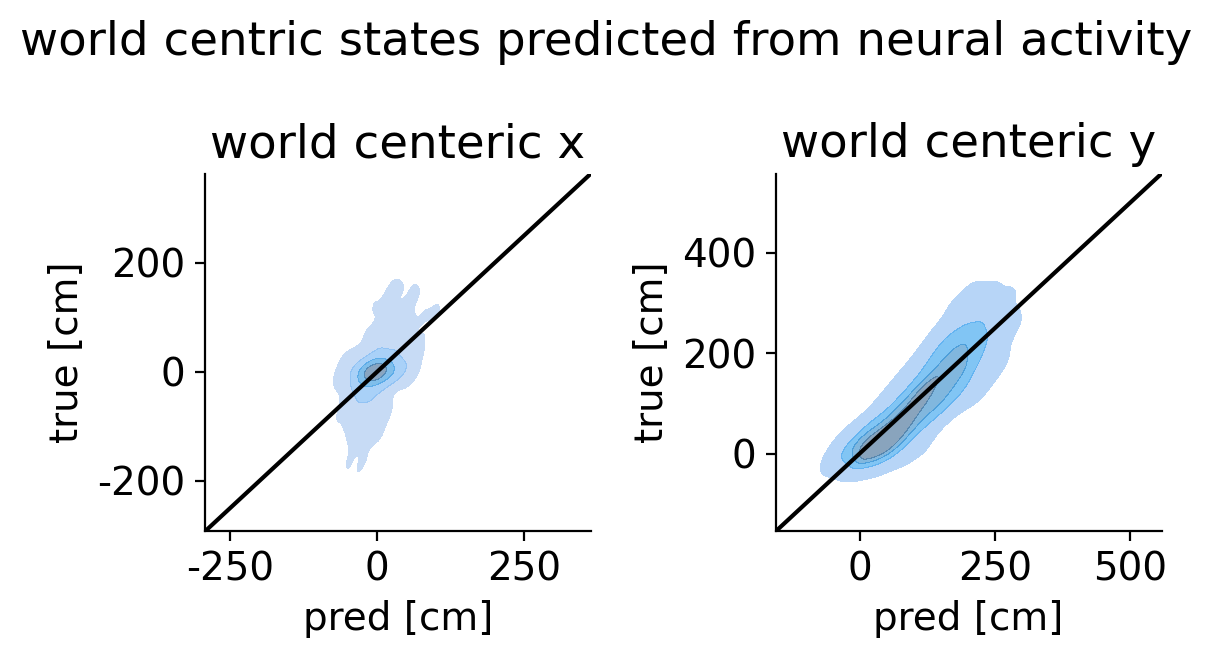

In [29]:
# world centric states

linreg = linear_model.LinearRegression()
linreg.fit(modelX, pos_xy)
print('linear regression score',linreg.score(modelX, pos_xy))
pred  = linreg.predict(modelX)
every=5
with initiate_plot(6, 3, 200) as f:
    ax=f.add_subplot(121)
    # plt.scatter(pred[::every,0],pos_xy[::every,0],s=1, alpha=0.3)
    thispred,thistrue=pred[::every,0],pos_xy[::every,0]
    predvstrue1(thispred,thistrue,ax)
    plt.xlabel('pred [cm]')
    plt.ylabel('true [cm]')
    plt.title('world centeric x')
    vmin,vmax=limplot(ax)
    ax.plot([vmin,vmax],[vmin,vmax],'k')
    quickspine(ax)
    ax=f.add_subplot(122)
    # plt.scatter(pred[::every,1],pos_xy[::every,1],s=1, alpha=0.3)
    thispred,thistrue=pred[::every,1],pos_xy[::every,1]
    predvstrue1(thispred,thistrue,ax)
    plt.xlabel('pred [cm]')
    plt.ylabel('true [cm]')
    plt.title('world centeric y')
    vmin,vmax=limplot(ax)
    ax.plot([vmin,vmax],[vmin,vmax],'k')
    quickspine(ax)
    plt.tight_layout()
    plt.suptitle('world centric states predicted from neural activity', y=1.1)


linear regression score 0.5649492612313365


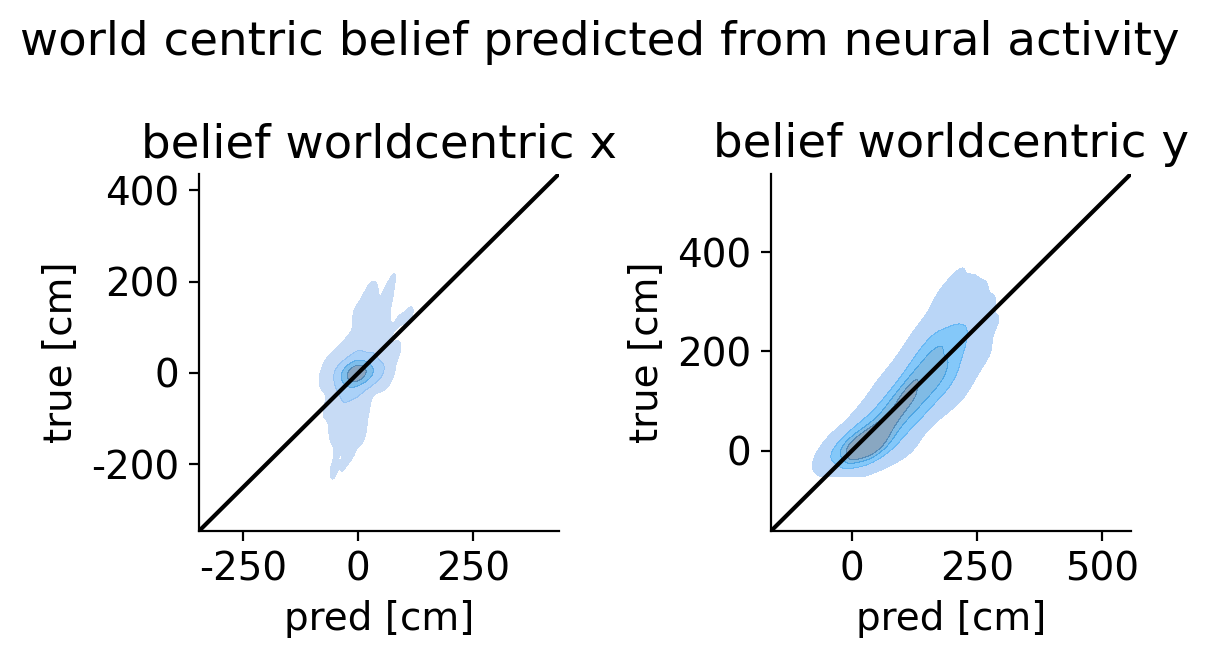

In [30]:
# world centric belief

linreg = linear_model.LinearRegression()
linreg.fit(modelX, belief_xy)
print('linear regression score',linreg.score(modelX, belief_xy))
pred  = linreg.predict(modelX)
every=5
with initiate_plot(6, 3, 200) as f:
    ax=f.add_subplot(121)
    thispred,thistrue=pred[::every,0],belief_xy[::every,0]
    predvstrue1(thispred,thistrue,ax)
    plt.xlabel('pred [cm]')
    plt.ylabel('true [cm]')
    plt.title('belief worldcentric x')
    vmin,vmax=limplot(ax)
    ax.plot([vmin,vmax],[vmin,vmax],'k')
    quickspine(ax)
    ax=f.add_subplot(122)
    thispred,thistrue=pred[::every,1],belief_xy[::every,1]
    predvstrue1(thispred,thistrue,ax)
    plt.xlabel('pred [cm]')
    plt.ylabel('true [cm]')
    plt.title('belief worldcentric y')
    vmin,vmax=limplot(ax)
    ax.plot([vmin,vmax],[vmin,vmax],'k')
    quickspine(ax)
    plt.tight_layout()
    plt.suptitle('world centric belief predicted from neural activity', y=1.1)

### self centric coord, neural activity --> states/belief 

compared to world centric, the self centric fitting is much better for both state and belief. 
this suggests that brain likely encodes position in a self centric manner rather than world centric.

also, the fitting quality for states/beliefs are similar.

linear regression score 0.5823302080258101


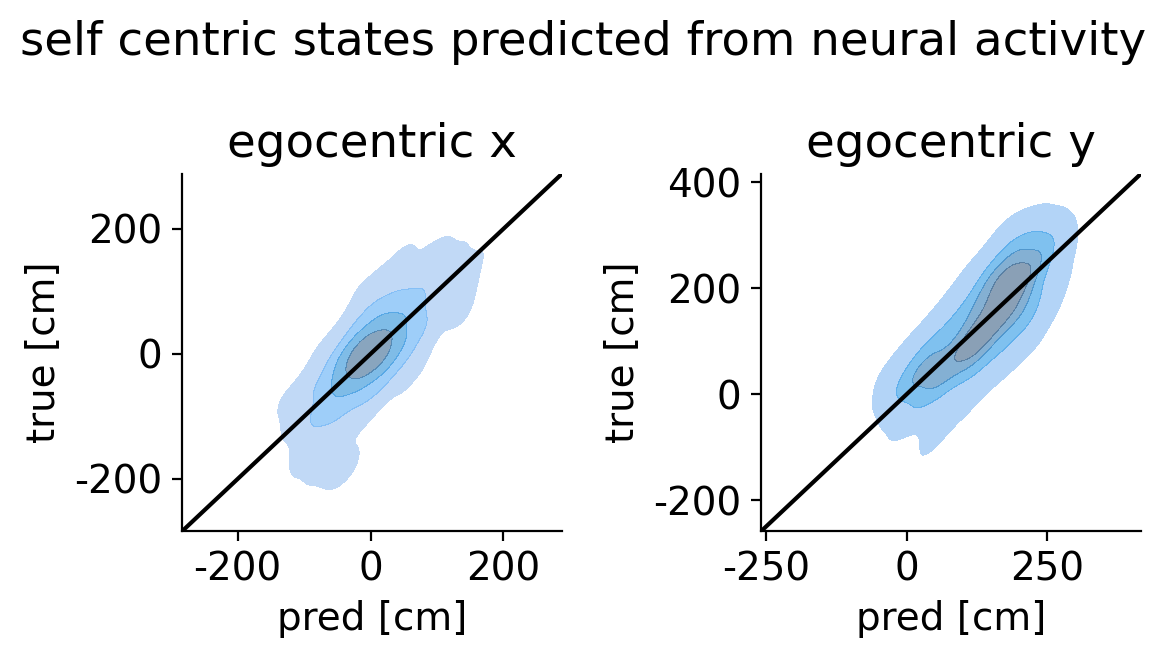

In [31]:
# mk centric, states

linreg = linear_model.LinearRegression()
linreg.fit(modelX, states_rel)
print('linear regression score',linreg.score(modelX, states_rel))
pred  = linreg.predict(modelX)
every=5
with initiate_plot(6, 3, 200) as f:
    ax=f.add_subplot(121)
    # plt.scatter(pred[::every,1],states_rel[::every,1],s=1, alpha=0.3)
    thispred,thistrue=pred[::every,0],states_rel[::every,0]
    predvstrue1(thispred,thistrue,ax)
    plt.xlabel('pred [cm]')
    plt.ylabel('true [cm]')
    plt.title('egocentric x')
    vmin,vmax=limplot(ax)
    ax.plot([vmin,vmax],[vmin,vmax],'k')

    ax=f.add_subplot(122)
    # plt.scatter(pred[::every,0],states_rel[::every,0],s=1, alpha=0.3)
    thispred,thistrue=pred[::every,1],states_rel[::every,1]
    predvstrue1(thispred,thistrue,ax)
    plt.xlabel('pred [cm]')
    plt.ylabel('true [cm]')
    plt.title('egocentric y')
    vmin,vmax=limplot(ax)
    ax.plot([vmin,vmax],[vmin,vmax],'k')
    plt.tight_layout()
    plt.suptitle('self centric states predicted from neural activity', y=1.1)


linear regression score 0.5905416016081555


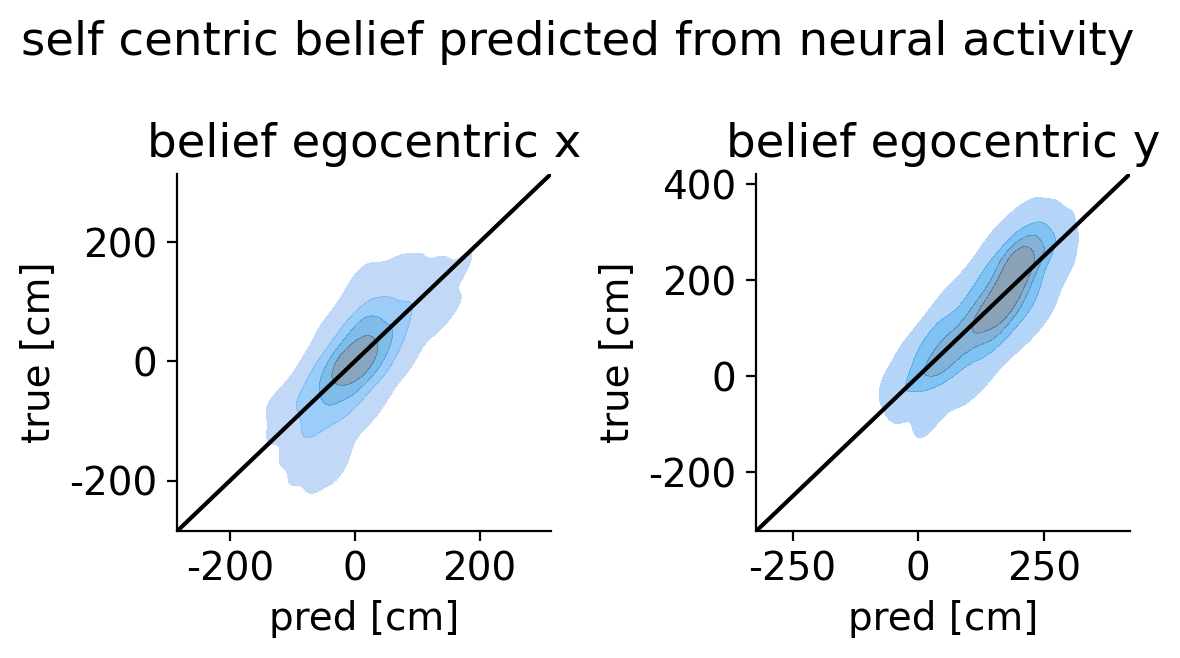

In [32]:
# mk centric, belief
trainx, trainy, testx, testy,mask=splitdataxy(modelX, belief_rel)
linreg = linear_model.LinearRegression()
linreg.fit(trainx, trainy)
print('linear regression score',linreg.score(testx, testy))
pred  = linreg.predict(testx)
# plot_pred(pred[:,0],testy[:,0], title='belief egocentric x', unit='cm',every=1)
# plot_pred(pred[:,1],testy[:,1], title='belief egocentric y', unit='cm',every=1)

with initiate_plot(6, 3, 200) as f:
    ax=f.add_subplot(121)
    thispred,thistrue=pred[::every,0],testy[::every,0]
    predvstrue1(thispred,thistrue,ax)
    plt.xlabel('pred [cm]')
    plt.ylabel('true [cm]')
    plt.title('belief egocentric x')
    vmin,vmax=limplot(ax)
    ax.plot([vmin,vmax],[vmin,vmax],'k')
    quickspine(ax)
    ax=f.add_subplot(122)
    thispred,thistrue=pred[::every,1],testy[::every,1]
    predvstrue1(thispred,thistrue,ax)
    plt.xlabel('pred [cm]')
    plt.ylabel('true [cm]')
    plt.title('belief egocentric y')
    vmin,vmax=limplot(ax)
    ax.plot([vmin,vmax],[vmin,vmax],'k')
    quickspine(ax)
    plt.tight_layout()
    plt.suptitle('self centric belief predicted from neural activity', y=1.1)


### polar coord, neural activity --> belief mu
skipping fitting to the states because we saw states are nearly the same as belief mu.

linear regression score 0.4787108581976531


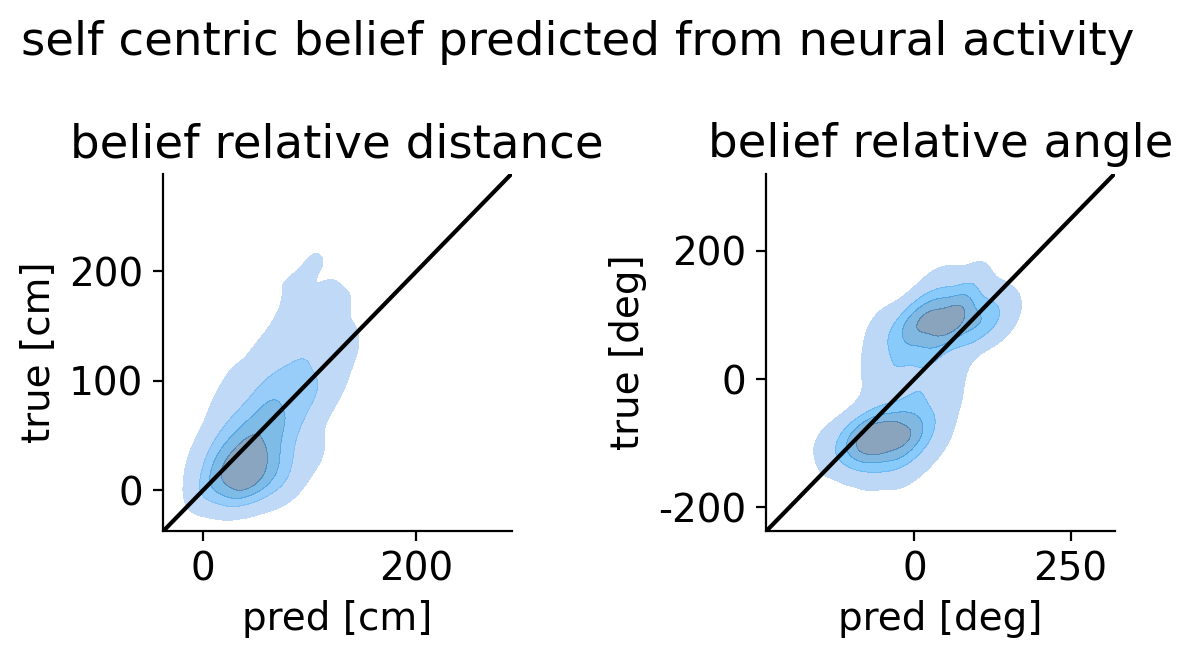

In [33]:
# polar, belief

# relative polar coord
def cordxy2pol(xr,yr,heading):
    # return distance, angle
    angle=np.arctan(xr,yr)*180/pi
    angle_rel=angle-heading
    distance=(xr**2 +yr**2)**0.5
    return distance, angle_rel

states_rel=np.hstack(states_rel).T
belief_heading = beliefs[:,2][non_nan]
belief_dist, belief_heading_rel=cordxy2pol(belief_rel[:,0].copy(),belief_rel[:,1].copy(),belief_heading)
belief_polar_rel=np.vstack([belief_dist, belief_heading_rel]).T

trainx, trainy, testx, testy,mask=splitdataxy(modelX, belief_polar_rel)
linreg = linear_model.LinearRegression()
linreg.fit(trainx, trainy)
print('linear regression score',linreg.score(testx, testy))
pred  = linreg.predict(testx)
# plot_pred(pred[:,0],testy[:,0], title='belief relative distance', unit='cm',every=1)
# plot_pred(pred[:,1],testy[:,1], title='belief relative angle', unit='degree',every=1)
 
with initiate_plot(6, 3, 200) as f:
    ax=f.add_subplot(121)
    # plt.scatter(pred[::every,1],states_rel[::every,1],s=1, alpha=0.3)
    thispred,thistrue=pred[::every,0],testy[::every,0]
    predvstrue1(thispred,thistrue,ax)
    plt.xlabel('pred [cm]')
    plt.ylabel('true [cm]')
    plt.title('belief relative distance')
    vmin,vmax=limplot(ax)
    ax.plot([vmin,vmax],[vmin,vmax],'k')

    ax=f.add_subplot(122)
    # plt.scatter(pred[::every,0],states_rel[::every,0],s=1, alpha=0.3)
    thispred,thistrue=pred[::every,1],testy[::every,1]
    predvstrue1(thispred,thistrue,ax)
    plt.xlabel('pred [deg]')
    plt.ylabel('true [deg]')
    plt.title('belief relative angle')
    vmin,vmax=limplot(ax)
    ax.plot([vmin,vmax],[vmin,vmax],'k')
    plt.tight_layout()
    plt.suptitle('self centric belief predicted from neural activity', y=1.1)



linear regression score 0.3800288549503269


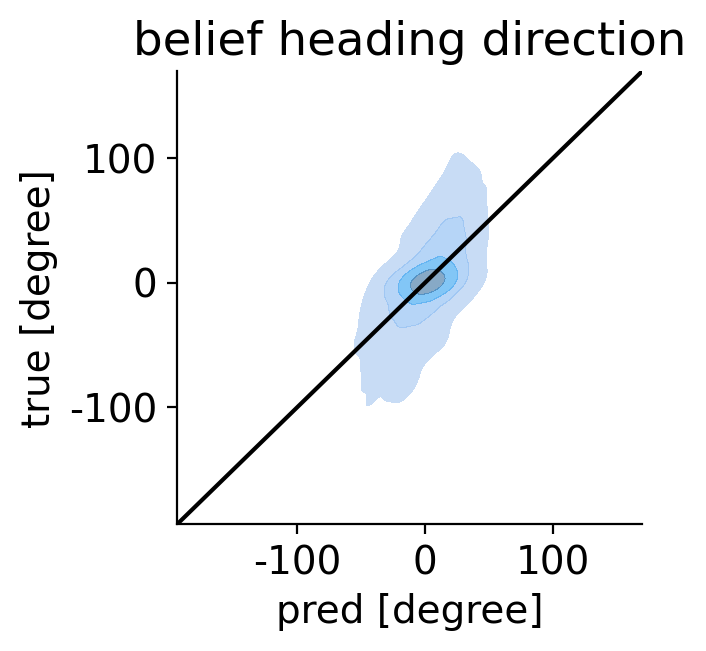

In [34]:
# r--> belief heading (world centric heading)
belief_heading = beliefs[:,2][non_nan]
trainx, trainy, testx, testy,mask=splitdataxy(modelX, belief_heading)
linreg = linear_model.LinearRegression()
linreg.fit(trainx, trainy)
print('linear regression score',linreg.score(testx, testy))
pred  = linreg.predict(testx)
plot_pred(pred,testy, title='belief heading direction', unit='degree',every=1)



### time

tiem grows linearly in a trial. 
there could be some neurons encoding time.
one thing to note is, in this model our uncertainty also grows linearly with time.
this time can also be intepreted as the growing uncertainty.

we found some neurons encode time pretty well.

also we tested if quadratic time 2 has a better fit.
turned out that it does not.

linear regression score 0.6965737297263279


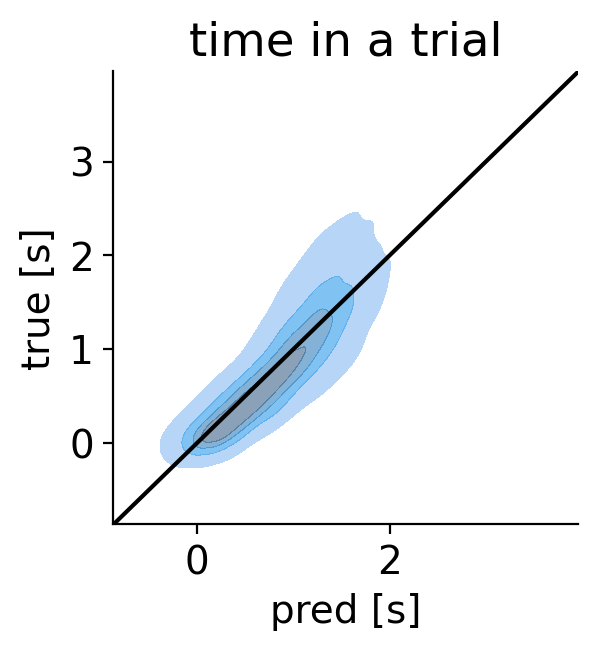

In [35]:
# r --> time in each trial

trialtime = []
fulltime = np.arange(0, 7, 0.1)
for itrial in range(len(trials)):
    thistime = len(X['x_monk'][trial_idx == trials[itrial]])
    trialtime.append(fulltime[:thistime])
trialtime = np.hstack(trialtime).T
len(trialtime)
trainx, trainy, testx, testy, mask = splitdataxy(modelX, trialtime)
linreg = linear_model.LinearRegression()
linreg.fit(trainx, trainy)
print('linear regression score', linreg.score(testx, testy))
pred = linreg.predict(testx)
plot_pred(pred, testy, title='time in a trial', unit='s', every=1)

linear regression score 0.5314725741228236


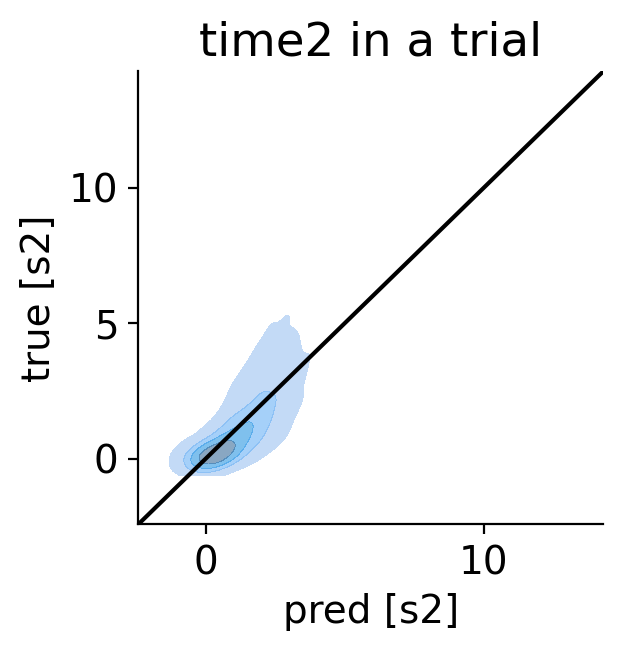

In [36]:
# r --> time2 in each trial

trialtime=[]
fulltime=np.arange(0,7,0.1)
for itrial in range(len(trials)):
    thistime=len(X['x_monk'][trial_idx==trials[itrial]])
    trialtime.append(fulltime[:thistime])
trialtime=np.hstack(trialtime).T
len(trialtime)
trialtime=trialtime**2

trainx, trainy, testx, testy,mask=splitdataxy(modelX, trialtime)
linreg = linear_model.LinearRegression()
linreg.fit(trainx, trainy)
print('linear regression score',linreg.score(testx, testy))
pred  = linreg.predict(testx)
plot_pred(pred,testy, title='time2 in a trial', unit='s2',every=1)
